# Load modules



In [1]:
import os
import tempfile
import copy, random, functools, pickle, math
import numpy as np
import pandas as pd
from multiprocessing import Pool
from scipy import stats
from functools import partial
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp

## Simulating cell fates

We define a clone through a record type, where we record when the clone was born (birthtime), when the cell left the clone (lifeTime), the random number generator used to determine the next fate (rng), whether the cell is a stem cell (stem) and the probability of dividing to give daughters with the same cell fate (e). We also include a list of other clones that the clone has given birth to (sibling), and an integer used to assign a unique identity to every cell created (identity). Note we have defined other elements in the record, which we use in future.

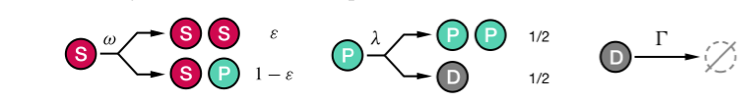

In [2]:
from IPython.display import Image
Image("cell_division.png")

## Cell fates

One stem cell could divide into either two stem cells (symmetrical cell division) or one stem cell and one progenitor cell (asymmetrical cell division). One progenitor cell could either divide into two progenitor cells (cell division) or differentiate into one differentiated cell (cell differentiation). 

For each stem cell, a random number (rand) is generated,
    
    if rand < e:         two stem cells are produced
    if e < rand <1:      one stem cell and one progenitor cells are produced
    
For each progenitor cell, another random number (rand) is generated:
    
    if rand < 0.5:       two stem-like cells are produced 
    if rand > 0.5:       two differentiated cells are produced
    
This simulation is applied to all cells if stem == True.

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


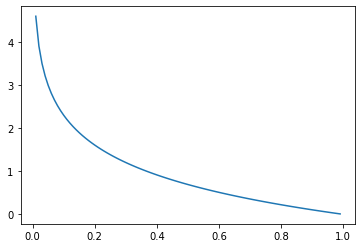

In [3]:
x = np.asarray(np.arange(start = 0, stop = 1, step = 0.01))
plt.plot(x, np.log(1/x))

In [4]:
class cell:
    def __init__(self,initialCell,stem,epsilon,randomNumberGenerator):
        
        # input variables:
        # initialCell: the birth time point of the initial stem cell or progenitor cell
        # stem: whether this initial cell is a stem-like cell        
        # epsilon: the probability of symmetrical division        
        # randomNumberGenerator: a random number generated between 0 and 1. 
        # Used to be compared with the epsilon, which leads to the fate (stemness) of the daughtor cells (self and sibling)                 
        
        self.currentTime = initialCell
        self.stem = stem
        self.epsilon = epsilon
        self.rng = randomNumberGenerator
        self.lifetime = 0
        self.birthtime = self.currentTime
        self.siblings = []
 
        # variables generated:
        # currentTime: current time point; redefined after each cell division
        # lifetime: the time point of death
        # siblings: a collection of cell fates of all the sibling cells generated from the initial cell
        
    def simulateStemCell(self,maxSimulation):
        
        # input variables:
        # self: the initial cell, including all the parameters e.g. stemness, epsilon
        # maxSimulation: the time point after the maximum number of division of the initial cell 
        # once the currentTime reaches maxSimulation, the division will stop
        
        cont = True
        while(cont):
            r = random.random()            
            if self.currentTime > maxSimulation:
                cont = False
            else:
                if self.stem:
#                     division time for stem cell
                    self.currentTime += np.log(1/r)/0.1        
#                     cell(initialCell,stem,epsilon,randomNumberGenerator)
                    sibling = cell(self.currentTime,self.stem,self.epsilon,self.rng)
                    rand = self.rng.random()
                    if rand < self.epsilon:
                        pass
                    else:
                        sibling.stem = False
                    self.siblings.append(sibling)
                else:
#                     division time for progenitor cell
                    self.currentTime += np.log(1/r)/1.5
            self.lifetime = self.currentTime
                    
    def simulateProgenitorCell(self,maxSimulation):
        
        # input variables:
        # self: the initial cell, including all the parameters e.g. stem-like, epsilon
        # maxSimulation: the time point after the maximum number of division of the initial cell
        # such that the progenitor cells divide more rapidly than the stem cells
        
        cont = True
        while(cont):
            r = random.random()
            if self.currentTime > maxSimulation:        
                cont = False
            else:
                # if stem-like cell
                if self.stem:
#                     division time for progenitor cells
                    self.currentTime += np.log(1/r)/1.5
                    sibling = cell(self.currentTime,self.stem,self.epsilon,self.rng)
                    rand = self.rng.random()
                    if rand < 0.5:
                        pass
                    else:
                        self.stem = False
                        sibling.stem = False
                    self.siblings.append(sibling)
                else:
                    # the apoptosis time for differentiated cells
                    self.currentTime += np.log(1/r)/0.74
            self.lifetime = self.currentTime

In [5]:
def simulateStemCloneCore(initialCell,cellFate,parent,nameMarker,maxSimulation):
    
    # input variables:
    # initialCell: the birth time point of each initial stem cell (self and sibling)
    # cellFate: includes birth time, life time, parent, and stemness
    # parent: the birth time point of the parent cell of the initial cell
    # nameMarker: a marker name given to the initial cell
    # maxSimulation: the time point after the maximum number of division of the initial cell 
    
    # simulation for the initial stem cell (self)         
    initialCell.simulateStemCell(maxSimulation)
    nameMarker[0]+=1
    name = nameMarker[0]
    cellFate.append((initialCell.birthtime,
                    initialCell.lifetime,
                    initialCell.stem)) 
    
    # simulation for the sibling cell (self.sibling)
    for sibling in initialCell.siblings:
        simulateStemCloneCore(sibling,cellFate,name,nameMarker,maxSimulation)
        
    # output variables:
    # cellFate: a collection of cell fates of all the cells generated (self and sibling) 
        
    return(cellFate)


def simulateStemClone(initialCell,maxSimulation):
    return(simulateStemCloneCore(initialCell=initialCell,cellFate=[],parent=-1,nameMarker=[-1],maxSimulation=maxSimulation))


def simulateProgenitorCloneCore(initialCell,cellFate,parent,nameMarker,maxSimulation):
    
    # input variables:
    # initialCell: the birth time point of each initial progenitor cell (self and sibling)
    # cellFate: includes birth time, life time, parent, and stem-like
    # parent: the birth time point of the parent cell of the initial cell
    # nameMarker: a marker name given to the initial cell
    # maxSimulation: the time point after the maximum number of division of the initial cell
        
    # simulation for the initial progenitor cell (self)         
    initialCell.simulateProgenitorCell(maxSimulation)
    nameMarker[0]+=1
    name = nameMarker[0]
    cellFate.append((initialCell.birthtime,
                     initialCell.lifetime,
                     initialCell.stem))
    
    # simulation for the sibling cell (self.sibling)
    for sibling in initialCell.siblings:
        simulateProgenitorCloneCore(sibling,cellFate,name,nameMarker,maxSimulation)
    
    # output variables:
    # cellFate: a collection of cell fates of all the cells generated (self and sibling) 
    
    return((cellFate)) 


def simulateProgenitorClone(initialCell,maxSimulation):
    return(simulateProgenitorCloneCore(initialCell=initialCell,cellFate=[],parent=-1,nameMarker=[-1],maxSimulation=maxSimulation))

In [6]:
'''
testing the stem cell model
'''
b = cell(initialCell=0, stem=True, epsilon=0.1, randomNumberGenerator=random)
stemCellFate = simulateStemClone(initialCell=b,maxSimulation=50)
stemCellFate
# output: cell fate, i.e. (birthtime, lifetime, stem)

[(0, 50.14805442838697, True),
 (4.793141133895085, 51.03800396647649, False),
 (5.8249823307131425, 52.02110409198543, False),
 (25.67597902128619, 50.13174702198596, False),
 (37.11929034111198, 50.18033791572977, False),
 (50.14805442838697, 50.14805442838697, True)]

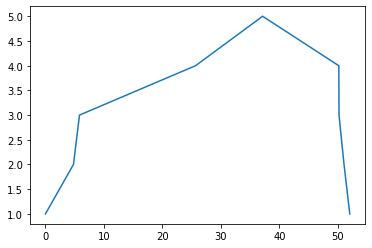

In [7]:
def cellDivisionTimeSeries(cellfate):
    birthtime = np.transpose(cellfate)[0]
    deathtime = np.transpose(cellfate)[1]
    time = np.sort(np.unique(np.append(birthtime, deathtime)))
    N = []
    for t in time:
        if t not in deathtime:
            N = np.append(N, 1)
        elif t not in birthtime:
            N = np.append(N, -1)
        else:
            N = np.append(N, 0)
    return{"time": time,"size": np.cumsum(N)}

stemCell = cellDivisionTimeSeries(stemCellFate)
plt.plot(stemCell["time"], stemCell["size"])
        

In [8]:
'''
testing the progenitor cell model
'''
c = cell(initialCell=0, stem=True, epsilon=0.5, randomNumberGenerator=random)
progenitorCellFate = simulateProgenitorClone(initialCell=c,maxSimulation=50)
progenitorCellFate
# output: cell fate, i.e. (birthtime, lifetime, stem)

[(0, 51.181831652077015, False), (2.273306992811855, 50.03801767924641, False)]

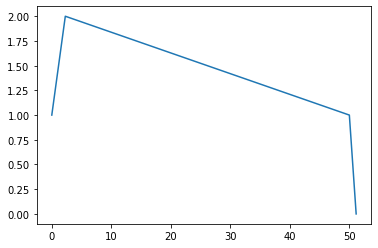

In [9]:
progenitorCell = cellDivisionTimeSeries(progenitorCellFate)
plt.plot(progenitorCell["time"], progenitorCell["size"])

In [10]:
def fateToCloneSize(clone,countingTimePoint):    
    # input variables:
    # clone: a collection of cell fates of all the cells in a clone 
    # countingTimePoint: the time point selected to count the cells in each clone    
    count = 0
    # counting based on birth time and life time of each cell    
    for (birthtime, lifetime, stem) in clone:        
        # firstly count the number of stem cells
        if stem == True:
            if birthtime <= countingTimePoint:
                count += 1
            else:
                count += 0        
        # secondly count the number of progenitor cells
        else:
            maxProgenitorSimulation = countingTimePoint - birthtime
            progenitorCell = cell(initialCell=0,stem=True,epsilon=0.5,randomNumberGenerator=random)
            progenitorClone = simulateProgenitorClone(initialCell=progenitorCell,maxSimulation=maxProgenitorSimulation)
            
            for (Birthtime, Lifetime, Stem) in progenitorClone:
                if (birthtime + Birthtime <= countingTimePoint) and (birthtime + Lifetime > countingTimePoint):
                    count += 1
                else:
                    count += 0
    
    # output variable:
    # count: cell count of each clone
    
    return(count)
        
def cloneGenerator(countingTimePoint,epsilon,N):
    
    # input variable:
    # countingTimePoint: the time point selected to count the cells in each clone
    # epsilon: the probability of symmetrical division of stem cells
    # N: the number of parallele tasks
    
    simulation = 1000
    # during each simulaion, a clonal growth is simulated
    maxStemSimulation = countingTimePoint
    def seedWrapper(epsilon,maxSimulation,seed):
        random.seed(seed)
        clone = cell(initialCell=0,stem=True,epsilon=epsilon,randomNumberGenerator=random)
        return(simulateStemClone(initialCell=clone,maxSimulation=maxSimulation))
    fates = np.asarray( [np.asarray(seedWrapper(epsilon,maxStemSimulation,N*simulation+i)) for i in range(simulation)] )
    return([(fateToCloneSize(clone,countingTimePoint)) for clone in fates])

def multiSimulation(N):
    # N: the number of parallele tasks    
    return(cloneGenerator(countingTimePoint=20,epsilon=0.1,N=N))


In [11]:
from multiprocessing import Pool

if __name__ == '__main__':
    with Pool(8) as p:
        %time results = p.map(multiSimulation, range(10))

CPU times: user 5.34 ms, sys: 2.35 ms, total: 7.68 ms
Wall time: 4.82 s


In [12]:
cloneSizes = np.concatenate(results)
np.shape(cloneSizes)

(10000,)

In [13]:
print(min(cloneSizes))

1


In [14]:
print(max(cloneSizes))

977


In [15]:
def negativeBinomialDistribution(divisionRate, countingTimePoint, n):
    n0 = divisionRate * countingTimePoint / 2
    N0 = np.log(n0)
    P = 1 / N0 * np.exp(-n/n0) / n
    return(P)

cloneSizeRange = np.array(range(max(cloneSizes)))
%time NBD = negativeBinomialDistribution(divisionRate=1.5, countingTimePoint=20, n=cloneSizeRange)

CPU times: user 690 µs, sys: 680 µs, total: 1.37 ms
Wall time: 938 µs


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


In [16]:
def checkingNegativeBinomialDistribution(cloneSizes,NBD):
#     minimum = min(cloneSizes)
#     print('minimum clone size = ' + str(minimum))
    maximum = max(cloneSizes)
    print('maximum clone size = ' + str(maximum))
    sizes = list(np.array(cloneSizes))
    freq = np.asarray([sizes.count(i+1) for i in range(maximum)])
    prob = freq/sum(freq)
    x = np.asarray(range(maximum))
    plt.bar(x,prob,width=2,color='y')
    plt.plot(x, NBD, 'r')
    plt.xlabel('clone size')
    plt.ylabel('proportion')
#     plt.yscale('log')
    
# checkingNegativeBinomialDistribution(cloneSizes)

maximum clone size = 977


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


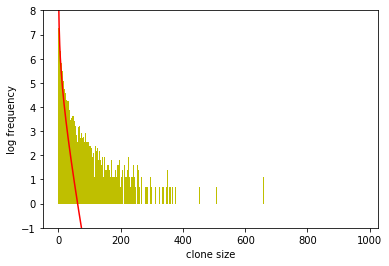

In [17]:
def logSizeDistribution(cloneSizes,NBD):
#     minimum = min(cloneSizes)
#     print('minimum clone size = ' + str(minimum))
    maximum = max(cloneSizes)
    print('maximum clone size = ' + str(maximum))
    x = np.asarray(range(maximum))
    sizes = list(np.array(cloneSizes))
    freq = np.asarray([sizes.count(i+1) for i in range(maximum)])
    plt.bar(x,np.log(freq),width=2,color='y') 
    plt.plot(x, np.log(len(cloneSizes)*NBD), 'r')
    plt.ylim((-1, 8))
    plt.xlabel('clone size')
    plt.ylabel('log frequency')
    
logSizeDistribution(cloneSizes,NBD)

In [18]:
# pickle_out = open("pickled_timepoint_15_simulation_10p4","wb")
# pickle.dump(test, pickle_out)
# pickle_out.close()

In [19]:
# pickle_in = open("pickled_timepoint_25","rb")
# cloneSizes = pickle.load(pickle_in)